# Setup

In [1]:
# General
library(tidyverse) # incl. ggplot2
library(reticulate)
#use_python("/Users/dominik.klein/opt/anaconda3/envs/mm_best_muon_full/bin/python3", required = TRUE)

# Analysis
library(Signac)
library(Seurat)
library(SeuratDisk)
library(SingleCellExperiment)
#library(pastecs)

# Plotting
library(cowplot)

#Set theme for plotting
##########################################
#theme_set(theme_bw())
theme_set(theme_cowplot())

# Borders around cowplots:
currentTheme <- theme_get()
currentTheme <- theme_replace(aspect.ratio = 1,
                              panel.border = element_rect(colour = "black", size = 0.75, fill = NA),
                              rect = element_rect(colour = "black", size = 0.5, linetype = 1, fill = "transparent"),
                              panel.background = element_rect(colour = "black", size = 0.5))
currentTheme <- theme_update(plot.title = element_text(hjust = 0.5))

library(future)
plan("multicore", workers=64)
options(future.globals.maxSize = 100 * 1024 ^ 3) # for 50 Gb RAM

# source("~/Scripts/R-Functions.R")
# 
# # Parallelization
# library(BiocParallel)
# register(MulticoreParam(32, progressbar = TRUE))

set.seed(1234)

── Attaching packages ─────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.8     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1
── Conflicts ────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Attaching SeuratObject

Attaching sp

Registered S3 method overwritten by 'SeuratDisk':
  method            from  
  as.sparse.H5Group Seurat

Lade nötiges Paket: SummarizedExperiment

Lade nötiges Paket: MatrixGenerics

Lade nötiges Paket: matrixStats


Attache Paket: ‘matrixStats’


Das folgende Objekt ist maskiert ‘package:dplyr’:

    count



Attache Paket: ‘MatrixGenerics’


Die folgenden Objekte sind maskiert von ‘package:matrixStats’:

    colAlls, colAnyNAs, c

In [2]:
#%%python
# General
#import scipy as sci
#import numpy as np
#import pandas as pd
#import logging
#import scipy.stats

# Analysis
#import scanpy as sc
#sc.logging.print_versions()

# Doublets Removed
## Load Data

In [3]:
# read preprocessed data
seurat <- readRDS("/Users/dominik.klein/data/E14-E15_adata_filtered_rmDoublets_seurat_jointPeaks.rds")

In [4]:
#%%python
#filtered = sc.read('/Users/dominik.klein/data/E14-E15_adata_filtered_rmDoublets.h5ad')

#filtered_var=list(filtered.var_names)
filtered_var = read_csv('/Users/dominik.klein/data/filtered_vars_helper.h5ad')

New names:
• `` -> `...1`
Rows: 18768 Columns: 2
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (1): 0
dbl (1): ...1

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [5]:
# Filter genes
seurat[["RNA"]] <- subset(seurat[["RNA"]], features = filtered_var$"0")
seurat[["RNA"]] 

Assay data with 18749 features for 16978 cells
First 10 features:
 Xkr4, Gm1992, Mrpl15, Lypla1, Gm37988, Tcea1, Rgs20, Atp6v1h, Oprk1,
Rb1cc1 

In [6]:
seurat@meta.data$sample <- sapply(rownames(seurat@meta.data), function(x){strsplit(x,"_")[[1]][1]})
Idents(seurat) <- seurat@meta.data$sample

## Preprocessing

In [ ]:
DefaultAssay(seurat) <- "RNA"
seurat <- SCTransform(seurat, verbose = TRUE, return.only.var.genes = FALSE, variable.features.n = NULL, vst.flavor = "v2")
seurat <- RunPCA(seurat)
seurat <- RunUMAP(seurat, dims = 1:50, reduction.name = 'umap.rna', reduction.key = 'rnaUMAP_')

vst.flavor='v2' set, setting model to use fixed slope and exclude poisson genes.



In [7]:
DefaultAssay(seurat) <- "peaks"
seurat <- RunTFIDF(seurat)
seurat <- FindTopFeatures(seurat, min.cutoff = 'q0')
seurat <- RunSVD(seurat)


Performing TF-IDF normalization

Running SVD

Scaling cell embeddings



Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“Zeichenbreite unbekannt für das Zeichen 0x9”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“Zeichenbreite unbekannt für das Zeichen 0x9”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“Zeichenbreite unbekannt für das Zeichen 0x9”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“Zeichenbreite unbekannt für das Zeichen 0x9”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“Zeichenbreite unbekannt für das Zeichen 0x9”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“Zeichenbreite unbekannt für das Zeichen 0x9”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“Zeichenbreite unbekannt für das Zeichen 0x9”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“Zeichenbreite unbe

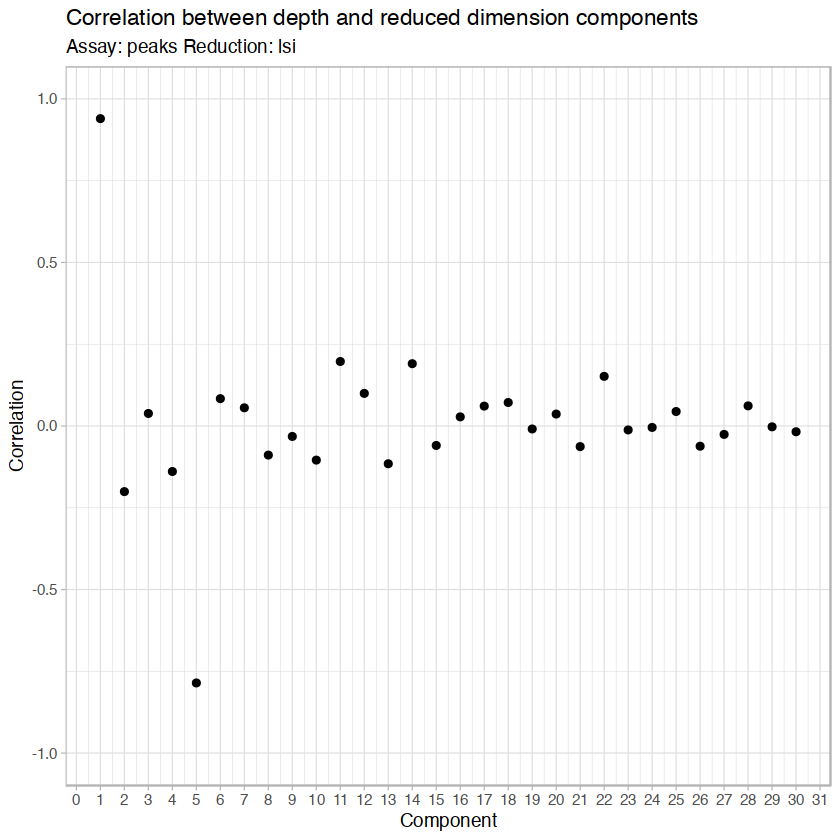

In [8]:
DepthCor(seurat, n=30) 

In [9]:
seurat_rm1 <- suppressMessages(RunUMAP(object = seurat, reduction = 'lsi', dims = c(2:40)))

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”


In [10]:
seurat_rm1 <- FindNeighbors(object = seurat_rm1, reduction = 'lsi', dims = c(2:40))

Computing nearest neighbor graph

Computing SNN



In [11]:
seurat_rm1 <- FindClusters(object = seurat_rm1, verbose = FALSE, algorithm = 3)

Warning message:
“UNRELIABLE VALUE: One of the ‘future.apply’ iterations (‘future_lapply-1’) unexpectedly generated random numbers without declaring so. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'future.seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'future.seed = NULL', or set option 'future.rng.onMisuse' to "ignore".”


In [12]:
dimplot1 <- DimPlot(object = seurat_rm1, label = TRUE) + NoLegend()

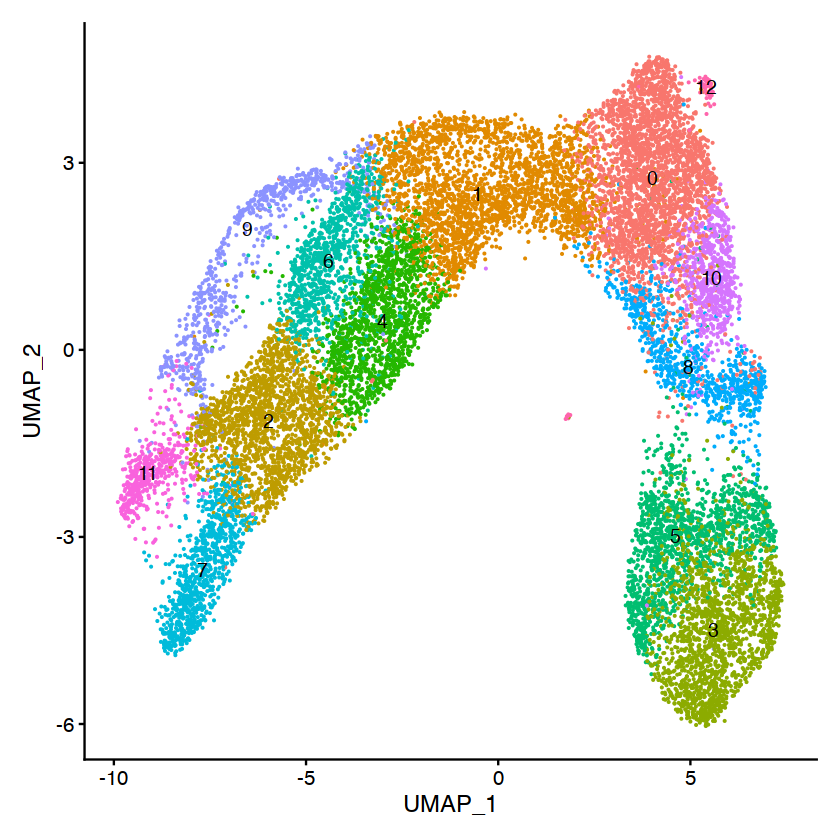

In [13]:
dimplot1

In [14]:
seurat_rm15 <- suppressMessages(RunUMAP(object = seurat, reduction = 'lsi', dims = c(1:4, 6:40)))

In [15]:
seurat_rm15 <- FindNeighbors(object = seurat_rm15, reduction = 'lsi', dims = c(1:4, 6:40))

Computing nearest neighbor graph

Computing SNN



In [16]:
seurat_rm15 <- FindClusters(object = seurat_rm15, verbose = FALSE, algorithm = 3)

Warning message:
“UNRELIABLE VALUE: One of the ‘future.apply’ iterations (‘future_lapply-1’) unexpectedly generated random numbers without declaring so. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'future.seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'future.seed = NULL', or set option 'future.rng.onMisuse' to "ignore".”


In [17]:
dimplot2 <- DimPlot(object = seurat_rm15, label = TRUE) + NoLegend()

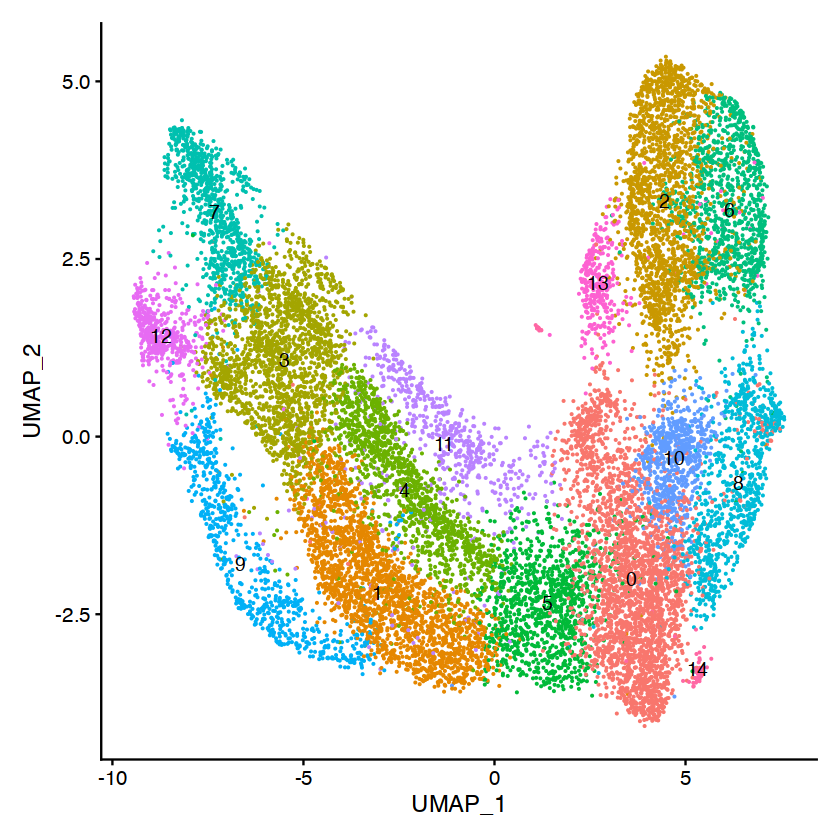

In [18]:
dimplot2

In [48]:
install.packages("anndata")

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [50]:
anndata::install_anndata()

+ '/Users/dominik.klein/Library/r-miniconda/bin/conda' 'install' '--yes' '--prefix' '/Users/dominik.klein/Library/r-miniconda/envs/r-reticulate' '-c' 'conda-forge' 'anndata>=0.7.5'



In [51]:
#adata <- anndata::AnnData(X = t(seurat_rm1[['peaks']]@data))

In [56]:
DefaultAssay(seurat_rm1)

[1] "peaks"

In [61]:
seurat_rm1

An object of class Seurat 
508985 features across 16978 samples within 3 assays 
Active assay: peaks (261915 features, 261915 variable features)
 2 other assays present: RNA, ATAC
 2 dimensional reductions calculated: lsi, umap

In [62]:
adata <- anndata::AnnData(X=matrix(0, 16978, 1))

In [63]:
adata$obsm[['lsi_full']] <- Embeddings(seurat_rm1, reduction = "lsi")
adata$obsm[['lsi_red']] <- Embeddings(seurat_rm1, reduction = "lsi")[,c(2:40)]

In [65]:
adata$obs = seurat_rm1@meta.data

In [66]:
adata$write_h5ad("/Users/dominik.klein/data/E14-E15_adata_filtered_rmDoublets_lsi_peaks_to_adata.h5ad",
                compression = "gzip")

None

In [54]:
# Add meta data
#adata$obs = seurat_rm1@meta.data

# Save binarized counts
#adata$obsm[['peaks']] <- seurat_rm1[['peaks']]@counts

# Save peak names
#adata$uns[['peak_names']] <- rownames(seurat_rm1[['peaks']]@counts)

# Save LSI and UMAP embeddings
#adata$obsm[['lsi_full']] <- Embeddings(seurat_rm1, reduction = "lsi")
#adata$obsm[['lsi_red']] <- Embeddings(seurat_rm1, reduction = "lsi")[,c(2:40)]

#adata$obsm[['umap']] <- Embeddings(seurat_rm1, reduction = "umap")

In [ ]:
#seurat <- RunUMAP(seurat, reduction = 'lsi', dims = 2:50, reduction.name = "umap.atac", reduction.key = "atacUMAP_")

## Weighted Nearest Neighbor Analysis

In [ ]:
# build a joint neighbor graph using both assays
seurat <- FindMultiModalNeighbors(
  object = seurat,
  reduction.list = list("pca", "lsi"), 
  dims.list = list(1:50, 2:50),
  modality.weight.name = "RNA.weight",
  verbose = TRUE
)

# build a joint UMAP visualization
DefaultAssay(seurat) <- "SCT"
seurat <- RunUMAP(
  object = seurat,
  nn.name = "weighted.nn",
  assay = "SCT",
  verbose = TRUE
)

seurat <- RunSPCA(seurat, assay = 'SCT', graph = 'wsnn', npcs = 50)

In [ ]:
DimPlot(seurat, label = TRUE, repel = TRUE, reduction = "umap.rna") + NoLegend() + ggtitle("RNA")
DimPlot(seurat, label = TRUE, repel = TRUE, reduction = "umap.atac") + NoLegend() + ggtitle("ATAC")
DimPlot(seurat, label = TRUE, repel = TRUE, reduction = "umap") + NoLegend() + ggtitle("WNN")

## Export Results

In [ ]:
saveRDS(seurat, "/Users/dominik.klein/data/E14-E15_adata_filtered_rmDoublets_seurat_jointPeaks_sctNormalized_wnn.rds")

In [ ]:
seurat_export <- seurat
Assays(seurat_export)
DefaultAssay(seurat_export) <- 'SCT'
#seurat_export[["RNA"]] <- NULL
seurat_export[["ATAC"]] <- NULL
seurat_export[["peaks"]] <- NULL

SaveH5Seurat(seurat_export, filename = "/Users/dominik.klein/data/E14-E15_adata_filtered_rmDoublets_sctNormalized_wsnn.h5Seurat", overwrite = TRUE)
Convert("/Users/dominik.klein/data/E14-E15_adata_filtered_rmDoublets_sctNormalized_wsnn.h5Seurat", dest = "h5ad", overwrite = TRUE)

seurat_export@graphs$wsnn <- NULL

SaveH5Seurat(seurat_export, filename = "/Users/dominik.klein/data/E14-E15_adata_filtered_rmDoublets_sctNormalized_wknn.h5Seurat", overwrite = TRUE)
Convert("/Users/dominik.klein/data/E14-E15_adata_filtered_rmDoublets_sctNormalized_wknn.h5Seurat", dest = "h5ad", overwrite = TRUE)

In [ ]:
# Add feature meta data (since Seurat v4 -> will be fixed?)
var <- c('detection_rate','gmean', 'variance', 'residual_variance')
seurat_export[["SCT"]]@meta.features <- SCTResults(seurat_export[["SCT"]], slot = "feature.attributes")[, var]
seurat_export[["SCT"]]@meta.features$variable <- FALSE
seurat_export[["SCT"]]@meta.features[VariableFeatures(seurat_export[["SCT"]] ), "variable"] <- TRUE
colnames(seurat_export[["SCT"]]@meta.features) <- paste0("sct.", colnames(seurat_export[["SCT"]]@meta.features) )

# Convert to SingleCellExperiment
sce_export <- as.SingleCellExperiment(seurat_export)

# Add feature meta data (since Seurat v4 -> will be fixed?)
rowData(sce_export) <- seurat_export[["SCT"]]@meta.features

# Rename and add layers
SummarizedExperiment::assay(sce_export, i = 1) <- seurat_export[["SCT"]]@counts
SummarizedExperiment::assay(sce_export, i = 2) <- seurat_export[["SCT"]]@data
SummarizedExperiment::assay(sce_export, i = 3) <- seurat_export[["SCT"]]@scale.data
#SummarizedExperiment::assay(sce_export, i = 4) <- seurat_export[["RNA"]]@counts[rownames(seurat_export[["RNA"]]@counts),]
SummarizedExperiment::assayNames(sce_export) <- c("sct_counts", "sct_logcounts", "sct_scale_data") #, "raw_counts")

# Save to file
saveRDS(seurat_export, "/Users/dominik.klein/data/E14-E15_adata_filtered_rmDoublets_sctNormalized_seurat.rds")
saveRDS(sce_export, "/Users/dominik.klein/data/E14-E15_adata_filtered_rmDoublets_sctNormalized_sce.rds")

# Session Info

In [ ]:
sessionInfo()